# Processing data Using Machine Learning Classifiers

This notebook will transform data from a JSON file format submitted in the Kaggle competition Random Acts of Pizza and transform it into a dataframe that will include all features of interest to use machine learning classifiers and predict who will get a pizza or not.

## Steps to cover

1. Data exploration
2. Feature selection
3. Data Wrangling
5. Output file

# Data exploration

Data is presented in two JSON file sets: train and test. The test data includes the outcome of interest "requester received pizza" plus a ton of other interesting information that we can use to predict. Let's look at the data.

In [3]:
# First let's import libraries of interest
import json
import pandas as pd

# Install Libraries
!pip install textblob
!pip install langdetect

# Import libraries - Sentiment
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import nltk
nltk.download('vader_lexicon')
import re
import string
# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


#Visualizing Confusion Matrix using Heatmap
import seaborn as sns


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Zaptetra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
with open("../data/external/train.json") as f:
    data = json.load(f)
print(json.dumps(data[1], indent=4, sort_keys=True))

{
    "giver_username_if_known": "N/A",
    "number_of_downvotes_of_request_at_retrieval": 2,
    "number_of_upvotes_of_request_at_retrieval": 5,
    "post_was_edited": false,
    "request_id": "t3_rcb83",
    "request_number_of_comments_at_retrieval": 0,
    "request_text": "I spent the last money I had on gas today. Im broke until next Thursday :(",
    "request_text_edit_aware": "I spent the last money I had on gas today. Im broke until next Thursday :(",
    "request_title": "[Request] California, No cash and I could use some dinner",
    "requester_account_age_in_days_at_request": 501.11109953703703,
    "requester_account_age_in_days_at_retrieval": 1122.279837962963,
    "requester_days_since_first_post_on_raop_at_request": 0.0,
    "requester_days_since_first_post_on_raop_at_retrieval": 621.1270717592593,
    "requester_number_of_comments_at_request": 0,
    "requester_number_of_comments_at_retrieval": 1000,
    "requester_number_of_comments_in_raop_at_request": 0,
    "requeste

## What does it mean?

For those who are not familiar with Reddit and Random Acts of Pizza (I wasn't familiar either when I started the project), I present to you how this data looks like in their site. Not all the information appearing in here matches the information from the data, the reason is because there's more data available linked to the requester aside from the post itself. See figure 1 for reference.

![raop-example](./figures/01-raop-1.png)

Looking at the data, what stands out to me the most is:
- Upvotes/Downvotes
- Number of comments
- Time since publication
- Some say thanks, but are not tagged as "fulfilled"

Now let's look just to the single post to get the reference clearer.

![raop-example](./figures/01-raop-2.png)

Now inside the post we get to see some extra information, like the full title of the requester, the status (tagged as fulfilled) and the full post text. Additionally, the number of comments which can be read below the post that include the request status: who is willing to fulfill the request, how much money they are sending vs how much was actually sent, what pizza place, etc.

What stands out most:
- Title
- Text
- Upvotes
- Percentage of upvoted
- Number of comments
- Days since posted
- Tags (fulfilled, NSFW)

Now, we have access to the requester information:
- User subreddits
- User edited the post
- User flair

## Feature selection - Baseline model

In order to define the feature selection for our linear model we must choose features that are independent from each other and that we believe will be good predictors.

These are the features of interest after exploring the information available and looking the the actual post examples:

- Post upvotes
- Text length (word count)
- Text compound sentiment
- Title lenth (word count)
- Title sentiment
- Days since request
- User activity on redit (count of subreddits)
- Comment count after average request time
- User post's on redit at request (count)
- User posts's on raop (count)
- Account age (days)
- Request text

The response variable will be true or false.

# Data Wrangling

The next step is process the input date to create a dataframe with the features of interest for the baseline model.

In [5]:
# Create a df from json

df = pd.json_normalize(data)
df.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


In [6]:
# let's check all the variables
df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

## Data Transformation

Let's review the approapiate transformation for the variables of internest:

### Outcome variable - True False
**y** = requester_received_pizza


### Independent variables
**Post upvotes** = number_of_upvotes_of_request_at_retrieval - number_of_downvotes_of_request_at_retrieval

**Text length (word count)** = count(request_text)

**Text compound sentiment** = sentiment function (request_text)

**Title length (word count)** = count (request_title)

**Title sentiment** = sentiment function (request_title)

**Days since request** = requester_days_since_first_post_on_raop_at_retrieval - requester_days_since_first_post_on_raop_at_request

**User subs on (count of subreddits)** = requester_number_of_subreddits_at_request

**User activity comments** = requester_number_of_comments_at_retrieval - requester_number_of_comments_at_request

**User activity comments raop** = requester_number_of_comments_in_raop_at_retrieval - requester_number_of_comments_in_raop_at_request

**User posts reddit** = requester_number_of_posts_at_retrieval - requester_number_of_posts_at_request

**User posts raop** = requester_number_of_posts_on_raop_at_retrieval - requester_number_of_posts_on_raop_at_request

**Comment count** = request_number_of_comments_at_retrieval 

**User rate start** = requester_upvotes_plus_downvotes_at_request / requester_upvotes_plus_downvotes_at_request

**User rate end** = requester_upvotes_minus_downvotes_at_retrieval / requester_upvotes_plus_downvotes_at_retrieval

**Account age (days)** = day_request(requester_account_age_in_days_at_retrieval)

**Day of request (M-S)** = day_request(unix_timestamp_of_request)

**Day of the month of request** = day_month_request(unix_timestamp_of_request)

**Month of request** = month_request(unix_timestamp_of_request)

**Week of year of request)** = week_request(unix_timestamp_of_request)

**Request text** = request_text

Unused variables:
- post_was_edited
- request_id
- request_text_edit_aware
- unix_timestamp_of_request_utc

Requester info unused vairables:
- requester_account_age_in_days_at_request
- requester_subreddits_at_request
- requester_upvotes_minus_downvotes_at_request
- requester_user_flair
- requester_username


In [7]:
# functions required
from datetime import datetime
# Count words in a text
# Input: string
# Output: count of words
def count_words(string):
    word_list = string.split()
    num_words = len(word_list)
    return num_words

# test function
# count_words('I love chocolate and beef, please!')

# Provides compound sentiment of a text based on VADER Sentiment analysis
# Input: string
# Output: compound sentiment between -1 and 1 (Negative/Positive)
def sentiment_scores(sentence):
    
    # Create a sentiment analysis object
    sent = SentimentIntensityAnalyzer()
    sent_dict = sent.polarity_scores(sentence)
    
#     print("Pos: {}, Neu: {}, Neg: {}, Score: {}".format(sent_dict['pos'],sent_dict['neu'],
#                                                        sent_dict['neg'],sent_dict['compound']))
    
    if sent_dict['compound']>=0.2:
        sent_dict['class'] = 'Positive'
    elif sent_dict['compound']<= -0.2:
        sent_dict['class'] = 'Negative'
    else:
        sent_dict['class'] = 'Neutral'
    
#     return [sentence, sent_dict['pos'],
#                 sent_dict['neu'], sent_dict['neg'],
#                 sent_dict['compound'],sent_dict['class']]
    return sent_dict['compound']

def day_request(date_unix):

    # Generate result using pandas
    date = datetime.fromtimestamp(date_unix)
    day = date.strftime('%w')
    
    return int(day)

def month_request(date_unix):

    # Generate result using pandas
    date = datetime.fromtimestamp(date_unix)
    month = date.strftime('%m')
    
    return int(month)

def week_request(date_unix):

    # Generate result using pandas
    date = datetime.fromtimestamp(date_unix)
    week = date.strftime('%U')
    
    return int(week)

def day_month_request(date_unix):

    # Generate result using pandas
    date = datetime.fromtimestamp(date_unix)
    daymonth = date.strftime('%d')
    
    return int(daymonth)

def was_edited(post_edited):
    if post_edited=='True':
        post_edited = 1
    else:
        post_edited = 0
    
    return int(post_edited)

# day_month_request(1317852607)
# Check the function with an example
# sentiment_scores("70% of proud Georgians said they would ecstatically vote\
#                  and give their life for the great leader Trump in 2024.")

In [8]:
## Update dataframe with constructed variables

df['post_upvotes'] = df['number_of_upvotes_of_request_at_retrieval'] \
                     - df['number_of_downvotes_of_request_at_retrieval']
    
df['text_word_count'] = df['request_text'].apply(lambda x: count_words(x))
df['text_sentiment'] = df['request_text'].apply(lambda x: sentiment_scores(x))
df['title_word_count'] = df['request_title'].apply(lambda x: count_words(x))
df['title_sentiment'] = df['request_title'].apply(lambda x: sentiment_scores(x))
df['days_since_request'] = df['requester_days_since_first_post_on_raop_at_retrieval'] \
                           - df['requester_days_since_first_post_on_raop_at_request']
    
df['user_activity_comments'] = df['requester_number_of_comments_at_retrieval'] \
                               - df['requester_number_of_comments_at_request']
df['user_activity_comments_raop'] = df['requester_number_of_comments_in_raop_at_retrieval']\
                                    - df['requester_number_of_comments_in_raop_at_request']
    
df['user_posts_reddit'] = df['requester_number_of_posts_at_retrieval'] \
                          - df['requester_number_of_posts_at_request']

df['user_posts_raop'] = df['requester_number_of_posts_on_raop_at_retrieval'] \
                    - df['requester_number_of_posts_on_raop_at_request']

df['user_rate_start'] = df['requester_upvotes_plus_downvotes_at_request'] \
                        / df['requester_upvotes_plus_downvotes_at_request']

df['user_rate_end'] = df['requester_upvotes_minus_downvotes_at_retrieval'] \
                      / df['requester_upvotes_plus_downvotes_at_retrieval']

df['day_request'] = df['unix_timestamp_of_request'].apply(lambda x: day_request(x))
df['day_month_request'] = df['unix_timestamp_of_request'].apply(lambda x: day_month_request(x))
df['month_request'] = df['unix_timestamp_of_request'].apply(lambda x: month_request(x))
df['week_request'] = df['unix_timestamp_of_request'].apply(lambda x: week_request(x))
df['post_was_edited'] = df['post_was_edited'].apply(lambda x: was_edited(x))

df.rename(columns={'requester_number_of_subreddits_at_request':'num_subreddits',
                  'request_number_of_comments_at_retrieval':'request_comment_counts',
                  'requester_account_age_in_days_at_retrieval':'account_age'})

# df = df.drop(columns=['request_id',
#                  'request_text_edit_aware',
#                  'unix_timestamp_of_request',
#                  'unix_timestamp_of_request_utc',
#                  'requester_account_age_in_days_at_request',
#                  'requester_subreddits_at_request',
#                  'requester_upvotes_minus_downvotes_at_request',
#                  'requester_user_flair',
#                  'requester_username',
#                  'giver_username_if_known',                 
#                 ], axis=1)
df.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,user_activity_comments,user_activity_comments_raop,user_posts_reddit,user_posts_raop,user_rate_start,user_rate_end,day_request,day_month_request,month_request,week_request
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,0,0,1,1,NaN,1.000000,3,5,10,40
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,1000,0,11,2,1.0,0.381268,6,24,3,12
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,0,0,1,1,NaN,1.000000,3,26,10,43
3,N/A,0,1,0,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,5,2,1,1,1.0,0.728395,5,2,12,48
4,N/A,6,6,0,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,38,2,2,1,1.0,0.649179,5,12,7,27


In [9]:
df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [10]:
## Reduce the dataset to the variabels of interest

# df_2 = df.copy()

# Remove columns not used
df = df.drop(columns=['request_id','post_was_edited',
                      'giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 
       'request_number_of_comments_at_retrieval', 
       'request_text_edit_aware', 
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_minus_downvotes_at_retrieval',
       'requester_upvotes_plus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_retrieval', 'requester_user_flair',
       'unix_timestamp_of_request','unix_timestamp_of_request_utc',
#        'request_text','request_title',
       'requester_username'], axis=1)

# Clean values
# df_2['requester_received_pizza'] = df_2['requester_received_pizza'].apply(lambda x: 1 if (x==True) else 0 )
# df['post_was_edited'] = df['post_was_edited'].apply(lambda x: 0 if (x==False) else 1)
df['user_rate_start'] = df['user_rate_start'].fillna(df['user_rate_start'].median())
df['user_rate_end'] = df['user_rate_end'].fillna(df['user_rate_end'].median())
df.insert(len(df.columns)-1, 'requester_received_pizza', df.pop('requester_received_pizza'))

# round data
df = df.round(decimals=2)

df.head()

,request_text,request_title,post_upvotes,text_word_count,text_sentiment,title_word_count,title_sentiment,days_since_request,user_activity_comments,user_activity_comments_raop,user_posts_reddit,user_posts_raop,user_rate_start,user_rate_end,day_request,day_month_request,month_request,week_request,requester_received_pizza
0,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,1,67,0.83,6,0.61,792.42,0,0,1,1,1.0,1.00,3,5,10,40,False
1,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",3,16,-0.69,10,-0.30,621.13,1000,0,11,2,1.0,0.38,6,24,3,12,False
2,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",3,59,0.81,10,0.67,771.62,0,0,1,1,1.0,1.00,3,26,10,43,False
3,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",1,30,0.52,11,0.00,734.52,5,2,1,1,1.0,0.73,5,2,12,48,False
4,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,0,103,0.98,14,0.85,146.57,38,2,2,1,1.0,0.65,5,12,7,27,False


### Exploratory Data Analysis

In [11]:
df.describe()

,post_upvotes,text_word_count,text_sentiment,title_word_count,title_sentiment,days_since_request,user_activity_comments,user_activity_comments_raop,user_posts_reddit,user_posts_raop,user_rate_start,user_rate_end,day_request,day_month_request,month_request,week_request
count,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.0,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000
mean,3.755941,77.529208,0.512564,12.422525,0.053941,502.576198,174.327475,1.981683,19.550248,1.175495,1.0,0.492458,2.889851,15.902475,6.902475,28.009653
std,9.048429,71.281563,0.519856,6.965016,0.412741,270.740701,293.440622,4.883963,47.282088,0.481542,0.0,0.219908,1.971823,9.006250,2.978655,13.041278
min,-7.000000,0.000000,-0.990000,1.000000,-0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.560000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,35.000000,0.250000,8.000000,-0.250000,250.472500,2.000000,0.000000,1.000000,1.000000,1.0,0.360000,1.000000,8.000000,5.000000,19.000000
50%,2.000000,59.000000,0.740000,11.000000,0.000000,506.305000,28.000000,1.000000,4.000000,1.000000,1.0,0.530000,3.000000,16.000000,7.000000,29.000000
75%,4.000000,97.000000,0.920000,16.000000,0.400000,761.380000,185.000000,2.000000,18.000000,1.000000,1.0,0.630000,5.000000,24.000000,9.000000,37.000000
max,314.000000,854.000000,1.000000,52.000000,0.970000,1025.410000,1000.000000,135.000000,998.000000,9.000000,1.0,1.000000,6.000000,31.000000,12.000000,53.000000


/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

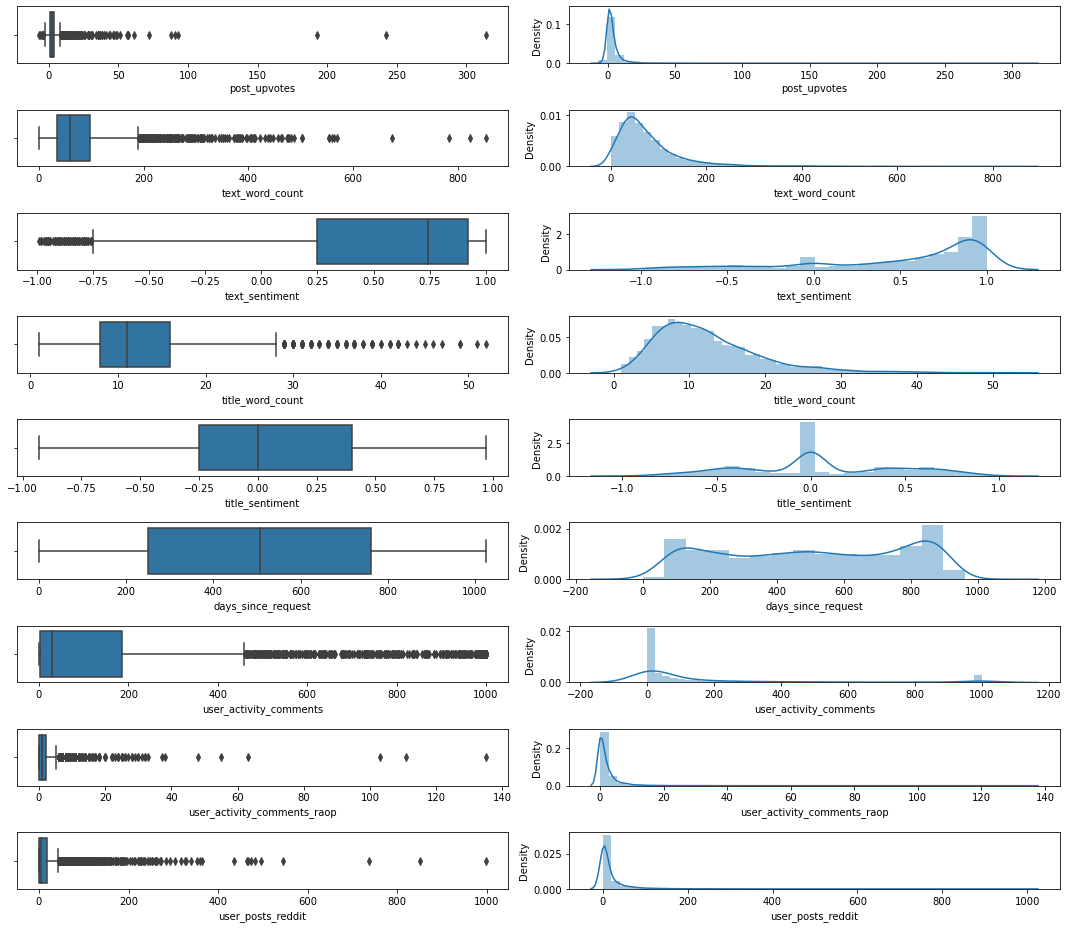

In [11]:
# Exploring the distribution and ranges of numeric features of interest

fig, ax = plt.subplots(9, 2, figsize = (15, 13))

sns.boxplot(x= df['post_upvotes'], ax = ax[0,0])
sns.distplot(df['post_upvotes'], ax = ax[0,1])
sns.boxplot(x= df["text_word_count"], ax = ax[1,0])
sns.distplot(df['text_word_count'], ax = ax[1,1])
sns.boxplot(x= df["text_sentiment"], ax = ax[2,0])
sns.distplot(df['text_sentiment'], ax = ax[2,1])
sns.boxplot(x= df["title_word_count"], ax = ax[3,0])
sns.distplot(df['title_word_count'], ax = ax[3,1])
sns.boxplot(x= df["title_sentiment"], ax = ax[4,0])
sns.distplot(df['title_sentiment'], ax = ax[4,1])
sns.boxplot(x= df["days_since_request"], ax = ax[5,0])
sns.distplot(df['days_since_request'], ax = ax[5,1])
sns.boxplot(x= df["user_activity_comments"], ax = ax[6,0])
sns.distplot(df['user_activity_comments'], ax = ax[6,1])
sns.boxplot(x= df["user_activity_comments_raop"], ax = ax[7,0])
sns.distplot(df['user_activity_comments_raop'], ax = ax[7,1])
sns.boxplot(x= df["user_posts_reddit"], ax = ax[8,0])
sns.distplot(df['user_posts_reddit'], ax = ax[8,1])

plt.tight_layout()

/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kanikamahajan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

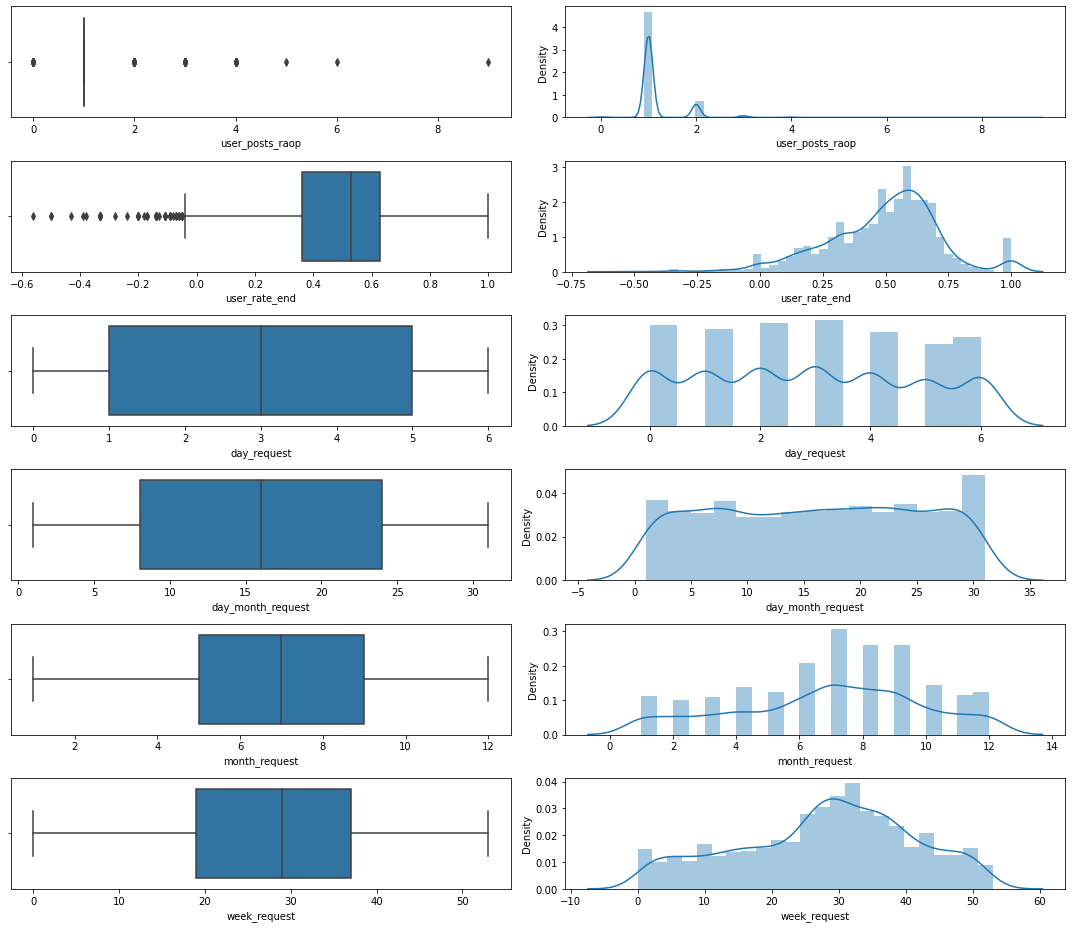

In [12]:
fig, ax = plt.subplots(6, 2, figsize = (15, 13))

sns.boxplot(x= df["user_posts_raop"], ax = ax[0,0])
sns.distplot(df['user_posts_raop'], ax = ax[0,1])
sns.boxplot(x= df["user_rate_end"], ax = ax[1,0])
sns.distplot(df['user_rate_end'], ax = ax[1,1])
sns.boxplot(x= df["day_request"], ax = ax[2,0])
sns.distplot(df['day_request'], ax = ax[2,1])
sns.boxplot(x= df["day_month_request"], ax = ax[3,0])
sns.distplot(df['day_month_request'], ax = ax[3,1])
sns.boxplot(x= df["month_request"], ax = ax[4,0])
sns.distplot(df['month_request'], ax = ax[4,1])
sns.boxplot(x= df["week_request"], ax = ax[5,0])
sns.distplot(df['week_request'], ax = ax[5,1])


plt.tight_layout()

In [19]:
df.shape

(4040, 19)

In [17]:
# Balance check (output variable)
total_true = df[df.requester_received_pizza == True]["requester_received_pizza"].count()
total_false = df[df.requester_received_pizza == False]["requester_received_pizza"].count()

total_true/(total_true + total_false)

0.24603960396039604

# Output file

In [11]:
# Now save for future use
# Will save as csv in data/interim

df.to_csv('../data/interim/logit_sentiments.csv', index=False)

# Check for correlated variables

After checking for correlated variables and drop them, we will create the final processed data to analyze.

In [70]:
# Load data
df = pd.read_csv('../data/interim/logit_sentiments.csv')
df=df.drop(columns=["user_rate_start"])

In [38]:
df.head()

,post_upvotes,text_word_count,text_sentiment,title_word_count,title_sentiment,days_since_request,user_activity_comments,user_activity_comments_raop,user_posts_reddit,user_posts_raop,user_rate_start,user_rate_end,day_request,day_month_request,month_request,week_request
0,1,67,0.83,6,0.61,792.42,0,0,1,1,1.0,1.00,3,5,10,40
1,3,16,-0.69,10,-0.30,621.13,1000,0,11,2,1.0,0.38,6,24,3,12
2,3,59,0.81,10,0.67,771.62,0,0,1,1,1.0,1.00,3,26,10,43
3,1,30,0.52,11,0.00,734.52,5,2,1,1,1.0,0.73,5,2,12,48
4,0,103,0.98,14,0.85,146.57,38,2,2,1,1.0,0.65,5,12,7,27


# Variance and Correlation
Looking at the Principal components - two of them explain most of the variance!

Component 1 - Explained variance 0.573
Component 2 - Explained variance 0.961
Component 3 - Explained variance 0.99
Component 4 - Explained variance 0.999
Component 5 - Explained variance 0.999
Component 6 - Explained variance 1.0
Component 7 - Explained variance 1.0
Component 8 - Explained variance 1.0
Component 9 - Explained variance 1.0
Component 10 - Explained variance 1.0
Component 11 - Explained variance 1.0
Component 12 - Explained variance 1.0
Component 13 - Explained variance 1.0
Component 14 - Explained variance 1.0


Text(0.5, 0, '# components')

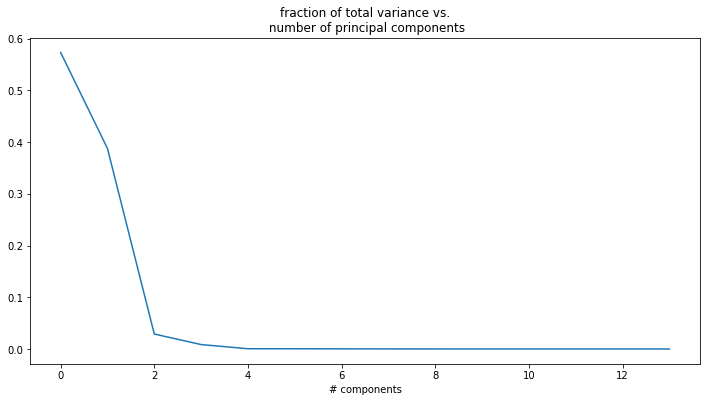

In [59]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: \ncomponents, Cols: Original dimensions')

# Data Handling for Model

X, Y = df.iloc[:,:-1], df.iloc[:,-1]

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

# Split into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=1)


# Principal Component Analysis on data
n_comp = df.shape[1]-1
plt.figure(figsize=(12, 6))

pca_mod = PCA(n_components = n_comp)
pca_mod.fit(X_train)
#     p2 = plt.subplot()
#     visualize_pca_comps_heatmap(p2, pca_mod.components_)

# Show the fraction of the total vriance in the training data by k components
[print(f"Component {i} - Explained variance {pca_mod.explained_variance_ratio_[:i].sum():.3}") \
 for i in range(1,df.shape[1])]

# Show a line plot of the fraction of total variance vs components
plt.subplot()
plt.plot(pca_mod.explained_variance_ratio_)
plt.title("fraction of total variance vs.\n number of principal components")
plt.xlabel("# components")

In [60]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                          Specs          Score
13                month_request  374960.053544
5            days_since_request      24.368802
12            day_month_request      10.912234
3              title_word_count      10.517748
9               user_posts_raop       8.156713
1               text_word_count       4.053188
10                user_rate_end       3.230382
11                  day_request       2.834228
7   user_activity_comments_raop       1.461477
4               title_sentiment       1.047079
8             user_posts_reddit       0.960153
6        user_activity_comments       0.045698
0                  post_upvotes       0.029605
2                text_sentiment       0.000153


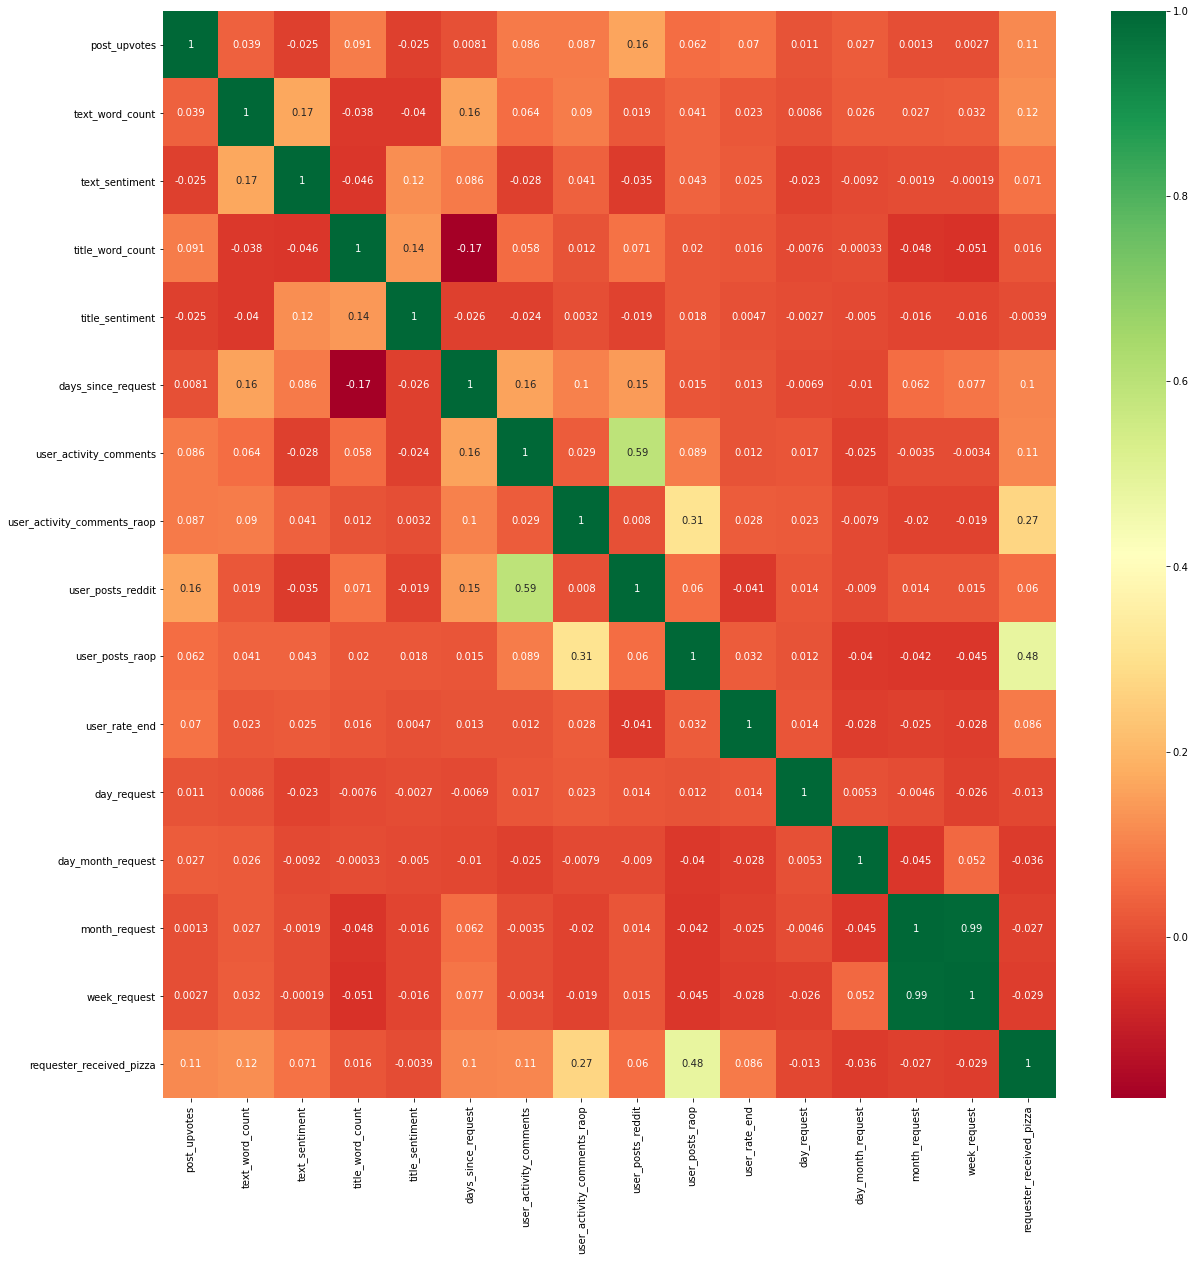

In [63]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [71]:
# Drop variables to avoid multicollinearity
df=df.drop(columns=["user_activity_comments_raop","week_request","user_posts_reddit"])
df.shape

(4040, 15)

## Notes
We selected features to move to the next analysis based on the feature selection: we removed correlated variables and noted the features that seem to be most important for our response variable.

Now we will save it as the processed (final data).

In [72]:
# Updated data including feature selection from meta variables
df.to_csv('../data/processed/logit_sentiments_feat_sel_meta.csv', index=False)
df.head()

,request_text,request_title,post_upvotes,text_word_count,text_sentiment,title_word_count,title_sentiment,days_since_request,user_activity_comments,user_posts_raop,user_rate_end,day_request,day_month_request,month_request,requester_received_pizza
0,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,1,67,0.83,6,0.61,792.42,0,1,1.00,3,5,10,False
1,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",3,16,-0.69,10,-0.30,621.13,1000,2,0.38,6,24,3,False
2,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",3,59,0.81,10,0.67,771.62,0,1,1.00,3,26,10,False
3,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",1,30,0.52,11,0.00,734.52,5,1,0.73,5,2,12,False
4,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,0,103,0.98,14,0.85,146.57,38,1,0.65,5,12,7,False
